In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def generateRiblets(d, h, theta, l):
    '''generates the vertices for a single riblet.  returns a list of 3D cartesian coords.
    d: riblet spacing
    h: riblet height
    theta: sharpness of riblet
    l: height of the system (distance to the lid driving the flow)'''
    w = h*math.tan(math.radians(theta/2)) #half of the base of the riblet triangle
    z = 0.1 #the length of the system in the z-direction.  Currently just used to make a dummy dimension for OpenFOAM's 2D quirks
    d_frac = 0.4 #the fraction of the separation used as the base for the trapezoid forming a side of the prism riblet
    
    vertices = [None]*6 #list to hold all the vertices
    vertices[0] = (0, 0, 0) #origin
    vertices[1] = ((1.-d_frac)*d, 0, 0) #RHS edge of first cuboid
    vertices[2] = (d, 0, 0) #base of riblet LHS
    vertices[3] = (d+2.*w, 0, 0) #base of riblet RHS
    vertices[4] = ((1.+d_frac)*d + 2.*w, 0, 0) #LHS of edge cuboid
    vertices[5] = (2.*(d+w), 0, 0) #RHS of system base
    
    vertices = [np.array(v) for v in vertices]
    
    vertices_h = [None]*5 #the next row of vertices at the height of the riblet peak
    vertices_h[0] = (0, h, 0)
    vertices_h[1] = ((1.-d_frac)*d, h, 0)
    vertices_h[2] = (d+w, h, 0)
    vertices_h[3] = ((1.+d_frac)*d + 2.*w, h, 0)
    vertices_h[4] = (2.*(d+w), h, 0)
    
    vertices_h = [np.array(v) for v in vertices_h]
    vertices_l = [v + np.array([0, (l-h), 0]) for v in vertices_h] #the top row of vertices at the top edge of the system
    
    vertices.extend(vertices_h)
    vertices.extend(vertices_l)
    
    for v in vertices:
        plt.scatter(v[0], v[1])
    plt.show()
    
    #vertices_other = vertices.copy() #duplicate of the vertices, but we add 0.1 to the z component as OpenFOAM requires 3D always
    vertices_other = [v + np.array([0., 0., z]) for v in vertices]
    
    vertices.extend(vertices_other)
    
    return vertices

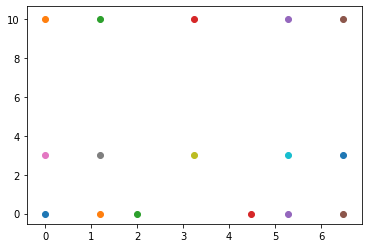

	(0.000  0.000  0.000)
	(1.200  0.000  0.000)
	(2.000  0.000  0.000)
	(4.485  0.000  0.000)
	(5.285  0.000  0.000)
	(6.485  0.000  0.000)
	(0.000  3.000  0.000)
	(1.200  3.000  0.000)
	(3.243  3.000  0.000)
	(5.285  3.000  0.000)
	(6.485  3.000  0.000)
	(0.000  10.000  0.000)
	(1.200  10.000  0.000)
	(3.243  10.000  0.000)
	(5.285  10.000  0.000)
	(6.485  10.000  0.000)
	(0.000  0.000  0.100)
	(1.200  0.000  0.100)
	(2.000  0.000  0.100)
	(4.485  0.000  0.100)
	(5.285  0.000  0.100)
	(6.485  0.000  0.100)
	(0.000  3.000  0.100)
	(1.200  3.000  0.100)
	(3.243  3.000  0.100)
	(5.285  3.000  0.100)
	(6.485  3.000  0.100)
	(0.000  10.000  0.100)
	(1.200  10.000  0.100)
	(3.243  10.000  0.100)
	(5.285  10.000  0.100)
	(6.485  10.000  0.100)


In [23]:
v = generateRiblets(2., 3., 45., 10.)
for i, elem in enumerate(v):
    #print("("+str(elem[0])+"\t"+str(elem[1])+"\t"+str(elem[2])+")")
    print("\t({0:5.3f}  {1:5.3f}  {2:5.3f})".format(elem[0], elem[1], elem[2]))